In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data -->

In [2]:
# hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

# hit_data_1056 = rf.get_ROOT_data_zip("TB_FIRE_1056_hits.root")

# hit_data_1057 = rf.get_ROOT_data_zip("TB_FIRE_1057_hits.root")

# hit_data_1079 = rf.get_ROOT_data_zip("TB_FIRE_1079_hits.root")

TB_FIRE_1101_hits.root finished


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes -->

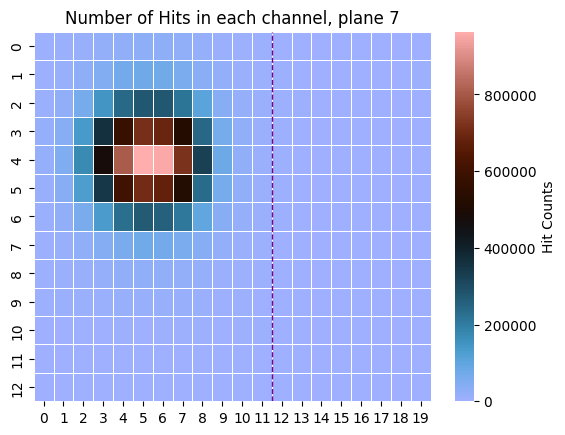

In [ ]:
# rf.hits_amount_colormap_single_plane(hit_data_1101, 7)

In [8]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 7, cmap="managua")

In [9]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 0, cmap="managua")

In [10]:
# rf.single_event_evolution_amp(hit_data_1101, 54106, cmap="managua")

In [11]:
# plt.clf()   # Clear the current figure
# plt.close() # Close any open figures
# %matplotlib widget
# rf.amp_histo_single_plane(hit_data_1101,1)

In [14]:
# rf.average_amp_vs_plane(hit_data_1101)

In [15]:
# # shower initial starting points
# rf.plot_empty_first_planes(hit_data_1101)

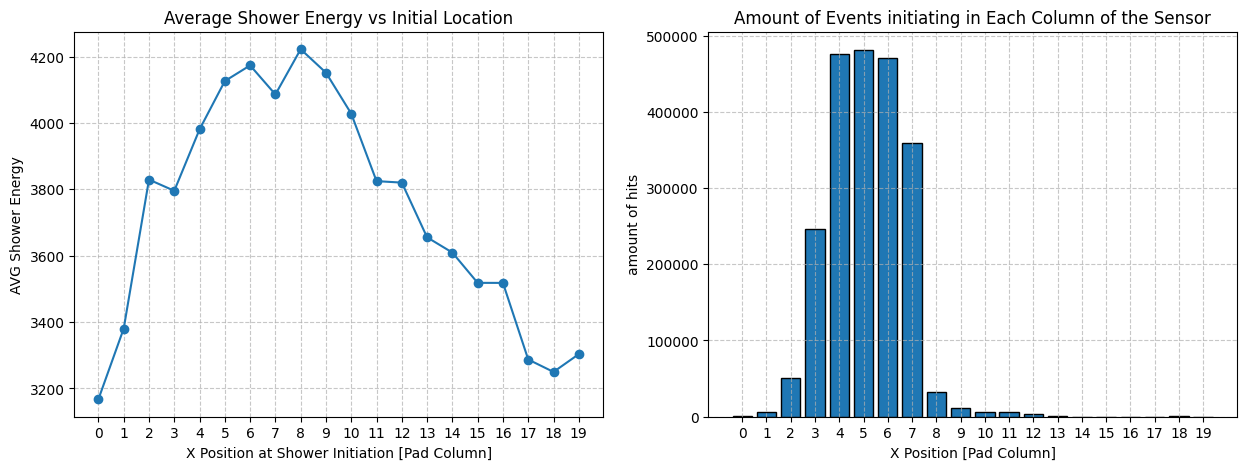

In [5]:
rf.event_shower_energy_vs_X_position(hit_data_1101)

In [ ]:
# returns histogram of the amount of hits with the same energy in given X position
def shower_energy_histo_single_location(hit_data, Position):

    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data_1101[hit_data_1101.plane == 7]
    mask = ak.num(plane_7) > 0
    first_plane_starting_events = hit_data_1101[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch
    # divide by x positions
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)
    print("avg ok")
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)
    print("shower per event ok")
    # get the shower energy for the X position for all events
    amps_divided_by_class, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    print("groupby ok")
    # div, avg_amps, classes = ak_groupby(x_avg, event_shower_amp_array)

    amps_class_position = amps_divided_by_class[amps_divided_by_class.classes == Position]
    print("amps class at position ok")
    amps_position = amps_class_position.data
    print("amp position ok")
    amps_position_clean = amps_position[ak.num(amps_position) > 0]
    print("amp position clean ok")




    # Plot
    plt.hist(amps_position_clean[0], bins=100, range=(0,500))
    plt.show()



In [8]:
# shower_energy_histo_single_location(hit_data_1101,5)


In [ ]:
# get the columns with the maximum amount of hits, k is the amount of wanted columns
def columns_with_max_hits(hit_data, number_of_columns):

    # get the initial x positions
    x_avg = rf.initial_X_position_DUT(hit_data)
    # x_avg = ak.round(x_avg)

    x_avg_np = ak.to_numpy(x_avg)

    # Compute histogram for X positions
    counts, bin_edges = np.histogram(x_avg, bins=np.arange(0, 21))

    # get the positions with the highest entries
    bins = np.arange(0, 20)

    # Get indices that would sort counts descending
    top_indices = np.argsort(-counts)[:number_of_columns]

    # Get the corresponding bin numbers
    top_bins = bins[top_indices]
    top_counts = counts[top_indices]

    return top_bins
    


In [ ]:
def avg_hit_amount_per_plane_per_X_position(hit_data, number_of_highest_ocupied_columns):

    # attach the positions to the data
    positions = rf.initial_X_position_DUT(hit_data)
    plane_7 = hit_data[hit_data.plane == 7]
    mask = ak.num(plane_7) > 0
    events_starting_at_7 = hit_data[mask]
    hit_data_positions = ak.zip({ "hits":events_starting_at_7, "position":positions},depth_limit=1)
    
    # get the most ocupied columns
    top_columns = columns_with_max_hits(hit_data, number_of_highest_ocupied_columns)

    # get the data of events initiating in the wanted column
    column = top_columns[0]
    hit_data_column = hit_data_positions[(hit_data_positions.positions >= column) & (hit_data_positions.positions < column + 1)]
    hit_data_column.hits[hit_data_column.hits.plane == column] # the events initiatin at the wanted column and a specific plane 

    # creat an array to store the amount of hits in each plane

    # find the amount of hits in a plane in the column and add to the array

    # divide the amount of hits by the amount of events to get the avg hit per shower in a plane

In [21]:
pos = rf.initial_X_position_DUT(hit_data_1101)


awkward.highlevel.Array

In [23]:
pos

<Array [4, 6, 4, 3, 5.5, 5, ..., 5, 3, 5, 7, 5.5, 4.5] type='2154539 * float64'>

In [27]:
plane_7 = hit_data_1101[hit_data_1101.plane == 7]
mask = ak.num(plane_7) > 0
hits_masked = hit_data_1101[mask]

In [71]:
hit_data_position = ak.zip({ "hits":hits_masked, "position":pos},depth_limit=1)
hit_data_column = hit_data_position[(hit_data_position.position >= 4) & (hit_data_position.position < 5)]
hit_data_column



<Array [{hits: [...], position: 4}, ..., {...}] type='476371 * {hits: var *...'>

In [77]:
hit_data_column.hits[hit_data_column.hits.plane == 7]

<Array [[{plane: 7, ch: 164, ...}], ..., [...]] type='476371 * var * {plane...'>

In [11]:
plane_7 = hit_data_1101[hit_data_1101.plane == 7]
plane_7_channel = plane_7.ch
plane_7_channel

<Array [[164], [], [186], [...], ..., [], [], []] type='2356797 * var * int32'>

In [15]:
y, x = divmod(plane_7_channel, 20)
x
x.

<Array [[True], [], [False], ..., [], [], []] type='2356797 * var * bool'>

(9, 4)